In [4]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from matplotlib import pyplot as plt
from netCDF4 import num2date
import numpy as np
import cftime
from copy import deepcopy

from dask_kubernetes import KubeCluster
from dask.distributed import Client, TimeoutError
from dask.distributed import wait, progress
#import six

## An example of using Dask with Australian Weather Radar Data

Note: The way Pangeo makes the Kube Cluster is it deploys the docker container you are working in to the cloud. So if you want the data available on the node you need to have the data uploaded on build.. Th

In [2]:
#As it can take some time to spin up first start the Dask cluster
# Select 20 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
try:
    client = Client('tcp://localhost:33949', timeout='2s')
    new_cluster = False
except:
    print('NOOO!')
    cluster = KubeCluster(n_workers=20)
    cluster
    new_cluster = True

NOOO!


In [3]:
cluster

In [28]:
def simple_sum(filename):
    try: #catch two common errors
        this_dataset = pyart.aux_io.read_odim_h5(filename)
        my_gatefilter = pyart.filters.GateFilter(this_dataset)
        my_gatefilter.include_all()
        my_gatefilter.exclude_invalid('reflectivity')
        my_gatefilter.exclude_above('differential_reflectivity', 6)
        my_gatefilter.exclude_below('differential_reflectivity', -4)
        my_gatefilter.exclude_below('cross_correlation_ratio', .65)
        
        fp = 1
        time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
        tgates = float(this_dataset.ngates*this_dataset.nrays)
        zdat = this_dataset.fields['reflectivity']['data']
        fp = 2
        z0 = float(len(np.where(zdat > 0.)[0]))/tgates
        z10 = float(len(np.where(zdat > 10.)[0]))/tgates
        z40 = float(len(np.where(zdat > 40.)[0]))/tgates
        
        
        linear_z = 10.0**(deepcopy(this_dataset.fields['reflectivity']['data'])/10.)
        linear_z[my_gatefilter.gate_excluded] = 0.0
        this_dataset.add_field_like('reflectivity', 'lin_reflectivity', linear_z, replace_existing=True)
        
        
                
        grids = pyart.map.grid_from_radars(this_dataset,(31,401,401),
                                           ((0.,15000.),(-200000.,200000.),(-200000.,200000.)),
                                           fields=['reflectivity','lin_reflectivity'] ,
                                           refl_field='reflectivity', weighting_function='BARNES2',
                                           gatefilter=my_gatefilter)  
        
        new_z = deepcopy(grids.fields['lin_reflectivity'])
        new_z_dbz = np.log10(new_z['data'])*10.0
        new_z['data'] = new_z_dbz
        grids.add_field('reflectivity_lingridded', new_z, replace_existing=True)
        
        z_prof_mean = grids.fields['reflectivity_lingridded']['data'].mean(axis=(1,2))
        z_prof_max = grids.fields['reflectivity_lingridded']['data'].max(axis=(1,2))
        
        npts_over_10 = np.array([float(len(np.where(grids.fields['reflectivity_lingridded']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity_lingridded']['data'].shape[0])])
        
        npts_over_50 = np.array([float(len(np.where(grids.fields['reflectivity_lingridded']['data'][i, :, :] > 50.)[0]))\
                      for i in range(grids.fields['reflectivity_lingridded']['data'].shape[0])])
        
        del this_dataset, grids
        
        rv = (time_start, z0, z10, z40, 
              z_prof_mean, z_prof_max, 
              npts_over_10, npts_over_50)
        
    except (TypeError, KeyError) as e:
        rv = 'error'
    return rv


In [6]:
indir = os.path.expanduser('~/data/aus/terryhills/')

In [7]:
files = os.listdir(indir)

In [8]:
files = [os.path.join(indir, thise) for thise in files]

In [30]:
time_start, z0, z10, z40, z_prof_mean, z_prof_max, npts_over_10, npts_over_50 =simple_sum(files[0])

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyart/filters/gatefilter.py:635: RuntimeWarning: invalid value encountered in greater
  marked = self._get_fdata(field) > value
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyart/filters/gatefilter.py:626: RuntimeWarning: invalid value encountered in less
  marked = self._get_fdata(field) < value
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


In [31]:
print(time_start, " ", npts_over_50)

2018-12-20 04:54:28   [1305. 1355. 1386. 1398. 1377. 1373. 1347. 1311. 1282. 1233. 1195. 1168.
 1143. 1093. 1054. 1004.  951.  886.  813.  740.  679.  595.  505.  419.
  315.  228.  148.   69.   22.    0.    0.]


In [12]:
# Attach Dask to the cluster
if new_cluster:
    client = Client(cluster)

In [13]:
client

Client Scheduler: tcp://10.48.160.7:39671 Dashboard: /user/openradar-ausopenradar2019-jytsui9r/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 140.00 GB


In [32]:
future = client.map(simple_sum, files)


In [33]:
progress(future)

VBox()

In [34]:
my_data = client.gather(future)

In [35]:

filtered_data = [value for value in my_data if type(value) != str]

In [36]:
times = np.array([tpl[0] for tpl in filtered_data])
z0 = np.array([tpl[1] for tpl in filtered_data])
z10 = np.array([tpl[2] for tpl in filtered_data])
z40 = np.array([tpl[3] for tpl in filtered_data])
zprof = np.array([tpl[4] for tpl in filtered_data])
zprofmax = np.array([tpl[5] for tpl in filtered_data])
npts_10 = np.array([tpl[6] for tpl in filtered_data])
npts_50 = np.array([tpl[7] for tpl in filtered_data])



In [37]:
order = np.argsort(times)

In [38]:
nptimes = times.astype('datetime64[ns]')

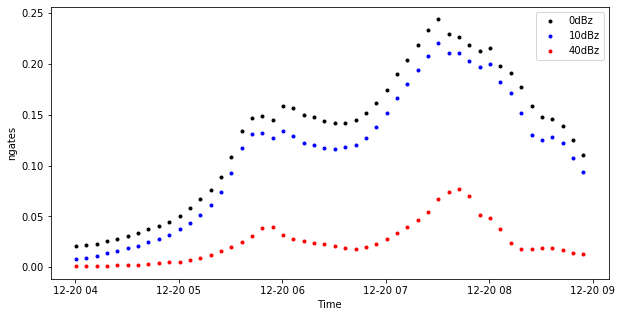

In [39]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(nptimes[order], z0[order], '.k', label='0dBz')
plt.plot(nptimes[order], z10[order], '.b', label='10dBz')
plt.plot(nptimes[order], z40[order], '.r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()

In [44]:
haxis = np.linspace(0,15., 31)

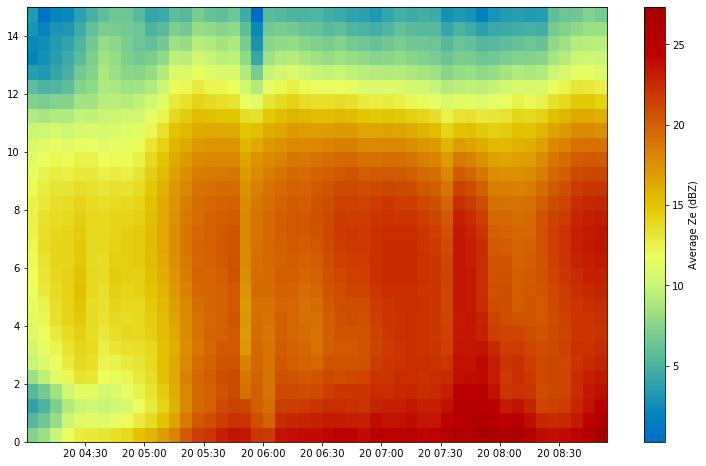

In [46]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(nptimes[order], haxis, zprof[order].transpose(),
              cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar(label='Average Ze (dBZ)')

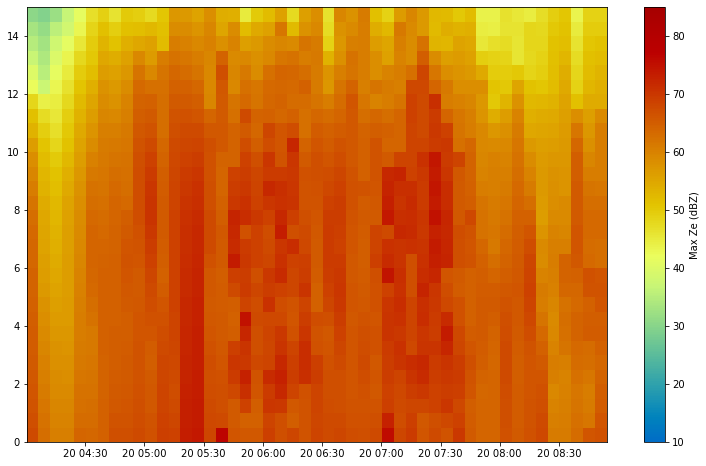

In [47]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(nptimes[order], haxis, zprofmax[order].transpose(), vmin=10, vmax=85,
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar(label='Max Ze (dBZ)')

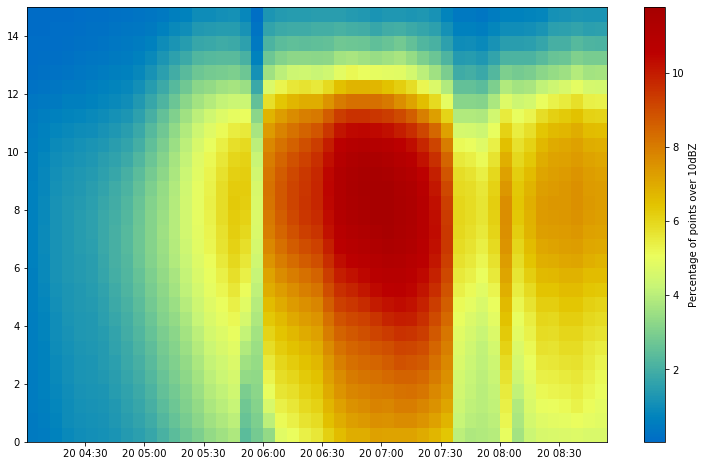

In [50]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(nptimes[order], haxis, 100.0*npts_10[order].transpose()/(801**2),
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar(label='Percentage of points over 10dBZ')

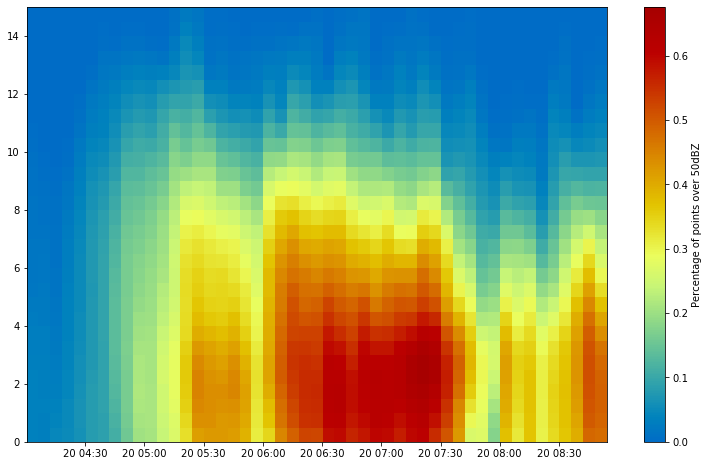

In [51]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(nptimes[order], haxis, 100*npts_50[order].transpose()/(801**2),
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar(label='Percentage of points over 50dBZ')